# Personal Financial Modelling
- src: https://github.com/chris1610/pbpython/blob/master/notebooks/Amortization-Model-Article.ipynb`

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt

In [2]:
def amortization_table(interest_rate, years, payments_year, principal, addl_principal=0, start_date=date.today()):
    """ Calculate the amortization schedule given the loan details
    
     Args:
        interest_rate: The annual interest rate for this loan
        years: Number of years for the loan
        payments_year: Number of payments in a year
        principal: Amount borrowed
        addl_principal (optional): Additional payments to be made each period. Assume 0 if nothing provided.
                                   must be a value less then 0, the function will convert a positive value to
                                   negative
        start_date (optional): Start date. Will start on first of next month if none provided

    Returns:
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    # Ensure the additional payments are negative
    if addl_principal > 0:
        addl_principal = -addl_principal
    
    # Create an index of the payment dates
    rng = pd.date_range(start_date, periods=years * payments_year, freq='MS')
    rng.name = "Payment_Date"
    
    # Build up the Amortization schedule as a DataFrame
    df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 
                                         'Addl_Principal', 'Curr_Balance'], dtype='float')
    
    # Add index by period (start at 1 not 0)
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"
    
    # Calculate the payment, principal and interests amounts using built in Numpy functions
    per_payment = np.pmt(interest_rate/payments_year, years*payments_year, principal)
    df["Payment"] = per_payment
    df["Principal"] = np.ppmt(interest_rate/payments_year, df.index, years*payments_year, principal)
    df["Interest"] = np.ipmt(interest_rate/payments_year, df.index, years*payments_year, principal)
        
    # Round the values
    df = df.round(2) 
    
    # Add in the additional principal payments
    df["Addl_Principal"] = addl_principal
    
    # Store the Cumulative Principal Payments and ensure it never gets larger than the original principal
    df["Cumulative_Principal"] = (df["Principal"] + df["Addl_Principal"]).cumsum()
    df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-principal)
    
    # Store the interest amt
    df["Cumulative_Interest"] = (df["Interest"]).cumsum()
    
    # Calculate the current balance for each period
    df["Curr_Balance"] = principal + df["Cumulative_Principal"]
    
    # Determine the last payment date
    try:
        last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=1, skipna=True)
    except ValueError:
        last_payment = df.last_valid_index()
    
    last_payment_date = "{:%m-%d-%Y}".format(df.loc[last_payment, "Payment_Date"])
        
    # Truncate the data frame if we have additional principal payments:
    if addl_principal != 0:
                
        # Remove the extra payment periods
        df = df.ix[0:last_payment].copy()
        
        # Calculate the principal for the last row
        df.ix[last_payment, "Principal"] = -(df.ix[last_payment-1, "Curr_Balance"])
        
        # Calculate the total payment for the last row
        df.ix[last_payment, "Payment"] = df.ix[last_payment, ["Principal", "Interest"]].sum()
        
        # Zero out the additional principal
        df.ix[last_payment, "Addl_Principal"] = 0
        
    # Get the payment info into a DataFrame in column order
    payment_info = (df[["Payment", "Principal", "Addl_Principal", "Interest"]]
                    .sum().to_frame().T)
       
    # Format the Date DataFrame
    payment_details = pd.DataFrame.from_items([('payoff_date', [last_payment_date]),
                                               ('Interest Rate', [interest_rate]),
                                               ('Number of years', [years])
                                              ])
    # Add a column showing how much we pay each period.
    # Combine addl principal with principal for total payment
    payment_details["Period_Payment"] = round(per_payment, 2) + addl_principal
    
    payment_summary = pd.concat([payment_details, payment_info], axis=1)
    return df, payment_summary

## Analysis

In [3]:
schedule1, stats1 = amortization_table(interest_rate = 0.035,
                                       years = 15,
                                       payments_year = 12,
                                       principal = 300000, 
                                       addl_principal = 0)

c:\users\tyler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


In [4]:
schedule1.head()

Payment_Date  Payment  Principal  Interest  Addl_Principal  \
Period                                                              
1        2019-12-01 -2144.65   -1269.65   -875.00               0   
2        2020-01-01 -2144.65   -1273.35   -871.30               0   
3        2020-02-01 -2144.65   -1277.06   -867.58               0   
4        2020-03-01 -2144.65   -1280.79   -863.86               0   
5        2020-04-01 -2144.65   -1284.53   -860.12               0   

        Curr_Balance  Cumulative_Principal  Cumulative_Interest  
Period                                                           
1          298730.35              -1269.65              -875.00  
2          297457.00              -2543.00             -1746.30  
3          296179.94              -3820.06             -2613.88  
4          294899.15              -5100.85             -3477.74  
5          293614.62              -6385.38             -4337.86

In [5]:
schedule1.tail()

Payment_Date  Payment  Principal  Interest  Addl_Principal  \
Period                                                              
176      2034-07-01 -2144.65   -2113.64    -31.00               0   
177      2034-08-01 -2144.65   -2119.81    -24.84               0   
178      2034-09-01 -2144.65   -2125.99    -18.66               0   
179      2034-10-01 -2144.65   -2132.19    -12.46               0   
180      2034-11-01 -2144.65   -2138.41     -6.24               0   

        Curr_Balance  Cumulative_Principal  Cumulative_Interest  
Period                                                           
176          8516.41            -291483.59            -85974.34  
177          6396.60            -293603.40            -85999.18  
178          4270.61            -295729.39            -86017.84  
179          2138.42            -297861.58            -86030.30  
180             0.01            -299999.99            -86036.54

In [6]:
stats1

payoff_date  Interest Rate  Number of years  Period_Payment   Payment  \
0  11-01-2034          0.035               15        -2144.65 -386037.0   

   Principal  Addl_Principal  Interest  
0 -299999.99             0.0 -86036.54

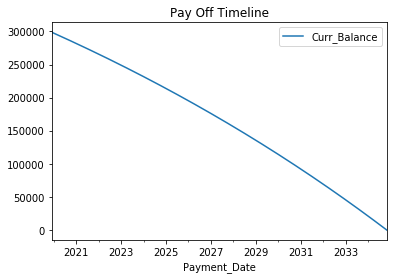

In [7]:
schedule1.plot(x='Payment_Date', y='Curr_Balance', title="Pay Off Timeline")
plt.show()

## Multiple loans of varying years...

c:\users\tyler\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


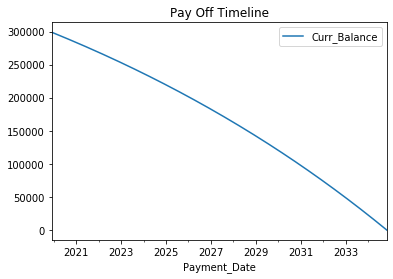

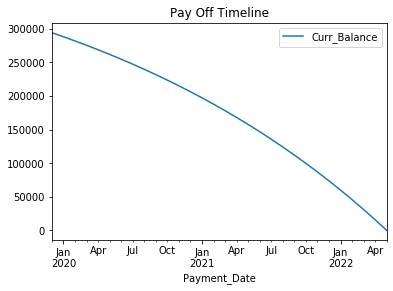

In [8]:
schedule1, stats1 = amortization_table(interest_rate = 0.047,
                                       years = 15,
                                       payments_year = 12,
                                       principal = 300000, 
                                       addl_principal = 0)
schedule2, stats2 = amortization_table(interest_rate = 0.035,
                                       years = 30,
                                       payments_year = 1,
                                       principal = 300000, 
                                       addl_principal = 0)
schedule1.plot(x='Payment_Date', y='Curr_Balance', title="Pay Off Timeline")
schedule2.plot(x='Payment_Date', y='Curr_Balance', title="Pay Off Timeline")
plt.show()

In [26]:
schedule1['Period'] = schedule1.index

In [27]:
schedule1.set_index('Payment_Date', inplace=True)

In [28]:
schedule1.head()

Payment  Principal  Interest  Addl_Principal  Curr_Balance  \
Payment_Date                                                               
2019-12-01   -2325.76   -1150.76  -1175.00               0     298849.24   
2020-01-01   -2325.76   -1155.27  -1170.49               0     297693.97   
2020-02-01   -2325.76   -1159.79  -1165.97               0     296534.18   
2020-03-01   -2325.76   -1164.34  -1161.43               0     295369.84   
2020-04-01   -2325.76   -1168.90  -1156.87               0     294200.94   

              Cumulative_Principal  Cumulative_Interest  Period  
Payment_Date                                                     
2019-12-01                -1150.76             -1175.00       1  
2020-01-01                -2306.03             -2345.49       2  
2020-02-01                -3465.82             -3511.46       3  
2020-03-01                -4630.16             -4672.89       4  
2020-04-01                -5799.06             -5829.76       5

# Global Date Table

In [29]:
# Global date table is required as it's a reference of all financial information
currentDate = date.today()
print(f'Todays Date: {currentDate}')

birthdate = '1993-04-28'
age = (date.today() - datetime.strptime(birthdate, '%Y-%m-%d').date()) // timedelta(days=365.2425)
male = True
female = False
print(f'Individual Details -Birthdate: {birthdate} - Age: {age} - Gender: {male}')

# Life expectancy
# https://www.aihw.gov.au/reports/life-expectancy-death/deaths-in-australia/contents/life-expectancy
if female:
    # Life expectancy (at birth): 84.6 years
    lifeExpectancyFemale = 84.6
    daysLeftAlive = lifeExpectancyFemale - age
#     lastDate = 
if male:
    # Life expectancy (at birth): 80.4 years
    lifeExpectancyMale = 80.4
    daysLeftAlive = (lifeExpectancyMale - age) * 365.2425
    lastDate = currentDate +timedelta(days=daysLeftAlive)
    print(f'Last Date: {lastDate}')

Todays Date: 2019-11-18
Individual Details -Birthdate: 1993-04-28 - Age: 26 - Gender: True
Last Date: 2074-04-12


### Creating global date table

In [30]:
freqReq = 'MS'
dateList = pd.date_range(currentDate, lastDate, freq = freqReq, closed='right').strftime('%Y-%m-%d').tolist()

In [31]:
dfInitData = np.zeros(shape= (len(dateList)+1))

In [32]:
globalDateDict = dict(zip(dateList, dfInitData))

In [33]:
dfGlobalDate = pd.DataFrame.from_dict(globalDateDict, orient='index')

In [34]:
dfGlobalDate

0
2019-12-01  0.0
2020-01-01  0.0
2020-02-01  0.0
2020-03-01  0.0
2020-04-01  0.0
...         ...
2073-12-01  0.0
2074-01-01  0.0
2074-02-01  0.0
2074-03-01  0.0
2074-04-01  0.0

[653 rows x 1 columns]

In [40]:
len(dfGlobalDate)

653

# Testing join functionality

In [35]:
schedule1.head(2)

Payment  Principal  Interest  Addl_Principal  Curr_Balance  \
Payment_Date                                                               
2019-12-01   -2325.76   -1150.76  -1175.00               0     298849.24   
2020-01-01   -2325.76   -1155.27  -1170.49               0     297693.97   

              Cumulative_Principal  Cumulative_Interest  Period  
Payment_Date                                                     
2019-12-01                -1150.76             -1175.00       1  
2020-01-01                -2306.03             -2345.49       2

In [41]:
df_dev = pd.merge(dfGlobalDate, schedule1, left_index=True, right_index=True, how='outer')

In [45]:
df_dev

0  Payment  Principal  Interest  Addl_Principal  Curr_Balance  \
2019-12-01  0.0 -2325.76   -1150.76  -1175.00             0.0     298849.24   
2020-01-01  0.0 -2325.76   -1155.27  -1170.49             0.0     297693.97   
2020-02-01  0.0 -2325.76   -1159.79  -1165.97             0.0     296534.18   
2020-03-01  0.0 -2325.76   -1164.34  -1161.43             0.0     295369.84   
2020-04-01  0.0 -2325.76   -1168.90  -1156.87             0.0     294200.94   
...         ...      ...        ...       ...             ...           ...   
2073-12-01  0.0      NaN        NaN       NaN             NaN           NaN   
2074-01-01  0.0      NaN        NaN       NaN             NaN           NaN   
2074-02-01  0.0      NaN        NaN       NaN             NaN           NaN   
2074-03-01  0.0      NaN        NaN       NaN             NaN           NaN   
2074-04-01  0.0      NaN        NaN       NaN             NaN           NaN   

            Cumulative_Principal  Cumulative_Interest  Period  
2019-12-01              -1150.76             -1175.00     1.0  
2020-01-01              -2306.03             -2345.49     2.0  
2020-02-01              -3465.82             -3511.46     3.0  
2020-03-01              -4630.16             -4672.89     4.0  
2020-04-01              -5799.06             -5829.76     5.0  
...                          ...                  ...     ...  
2073-12-01                   NaN                  NaN     NaN  
2074-01-01                   NaN                  NaN     NaN  
2074-02-01                   NaN                  NaN     NaN  
2074-03-01                   NaN                  NaN     NaN  
2074-04-01                   NaN                  NaN     NaN  

[653 rows x 9 columns]

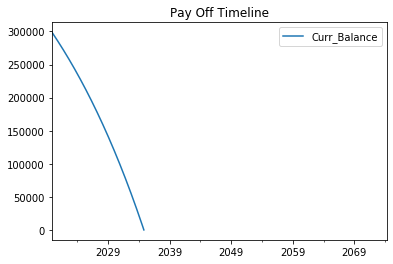

In [47]:
df_dev.plot(y='Curr_Balance', title="Pay Off Timeline")